In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
%time

Found GPU at: /device:GPU:0
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.15 µs


In [ ]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import glob
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.ndimage import interpolation as inter
from google.colab.patches import cv2_imshow
from tensorflow import keras 
from tensorflow.keras.models import Model
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
from google.colab import drive
drive.mount('./drive')

Mounted at ./drive


In [ ]:
labels = pd.read_csv("/content/drive/MyDrive/DeepLearningBootcamp/Training_set.csv")   # loading the labels
file_paths = [[fname, '/content/drive/MyDrive/DeepLearningBootcamp/train/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')

In [ ]:
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['label'])

In [ ]:
X, y = [],[]
image_size = 224

for i in range(len(train_data)):
  img = cv.imread(train_data['filepaths'][i])
  resized_img = cv.resize(img, (image_size, image_size))
  X.append(resized_img)
  y.append(train_data['label'][i])

In [ ]:
y = np.eye(5)[np.array(y).reshape(-1)].tolist()

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
X = X.reshape(-1, image_size, image_size, 3)
X.shape

(1048, 224, 224, 3)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state = 2)

In [ ]:
#X_train = X_train.reshape(-1, 56, 56, 3)
X_train = X_train.astype('float32')/255
X_val = X_val.astype('float32')/255

In [ ]:
X_train.shape , y_train.shape , X_val.shape

((838, 224, 224, 3), (838, 5), (210, 224, 224, 3))

In [ ]:
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))

for layers in vgg16_model.layers:
  layers.trainable = True

last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(32, activation = 'relu')(vgg_x)
vgg_x = Dense(5, activation = 'softmax')(vgg_x)

vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam',metrics=["accuracy",keras.metrics.Precision(),keras.metrics.Recall()])

In [ ]:
batch_size = 15
epochs = 50

vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)


vgg16_history = vgg16_final_model.fit(X_train,
                                      y_train, 
                                      batch_size=batch_size,
                                      epochs=epochs,
                                      validation_split=0.2,
                                      callbacks=[vgg_early_stopping],
                                      verbose=1)

Epoch 1/50
45/45 [==============================] - 12s 240ms/step - loss: 1.7380 - accuracy: 0.2164 - precision_20: 0.2045 - recall_20: 0.0134 - val_loss: 1.6094 - val_accuracy: 0.2798 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00
Epoch 2/50
45/45 [==============================] - 10s 232ms/step - loss: 1.4650 - accuracy: 0.3507 - precision_20: 0.7708 - recall_20: 0.1104 - val_loss: 1.1878 - val_accuracy: 0.4583 - val_precision_20: 0.9070 - val_recall_20: 0.2321
Epoch 3/50
45/45 [==============================] - 11s 234ms/step - loss: 1.3041 - accuracy: 0.4134 - precision_20: 0.8707 - recall_20: 0.1910 - val_loss: 1.2149 - val_accuracy: 0.4048 - val_precision_20: 0.9091 - val_recall_20: 0.2381
Epoch 4/50
45/45 [==============================] - 11s 236ms/step - loss: 1.3184 - accuracy: 0.4373 - precision_20: 0.8500 - recall_20: 0.2030 - val_loss: 1.1582 - val_accuracy: 0.5000 - val_precision_20: 0.9231 - val_recall_20: 0.2143
Epoch 5/50
45/45 [==========================

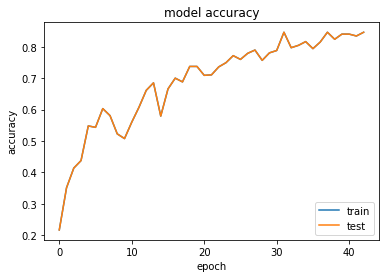

In [ ]:
import matplotlib.pyplot as plt
plt.plot(vgg16_history.history['accuracy'])
plt.plot(vgg16_history.history['accuracy'])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train','test'],loc='lower right')
plt.show()

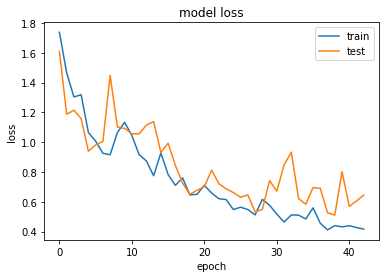

In [ ]:
import matplotlib.pyplot as plt
plt.plot(vgg16_history.history['loss'])
plt.plot(vgg16_history.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train','test'],loc='upper right')
plt.show()

In [ ]:
loss, accuracy, precision, recall = vgg16_final_model.evaluate(X_val, y_val, verbose=0)
print('Loss', loss)
print('Accuracy', accuracy)
print('Precision', precision)
print('Recall', recall)

f1_score = (2* recall*precision)/(recall+precision)
print("f1_score", f1_score)

Loss 0.4627944231033325
Accuracy 0.8238095045089722
Precision 0.8349514603614807
Recall 0.8190476298332214
f1_score 0.8269230844067222


Text(69.0, 0.5, 'Truth')

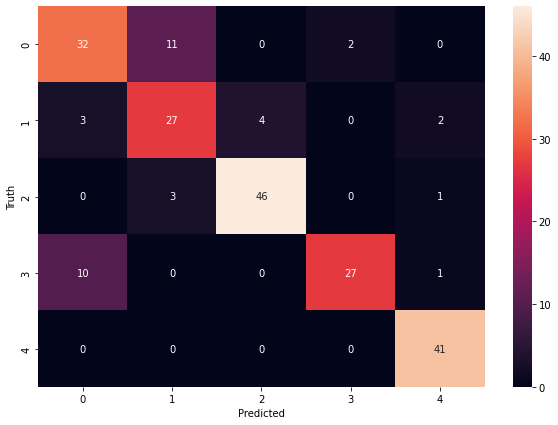

In [ ]:
predict = vgg16_final_model.predict(X_val)

result = []
correct = []
for i in predict:
  result.append(np.argmax(i))

for i in y_val:
  correct.append(np.argmax(i))

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(correct,result)

plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
vgg16_final_model.save('weather_81_75.h5')

In [ ]:
test_dataset = pd.read_csv("/content/drive/MyDrive/DeepLearningBootcamp/Testing_set.csv")
file_paths_test = [[fname, '/content/drive/MyDrive/DeepLearningBootcamp/test/' + fname] for fname in test_dataset['filename']]
test_images = pd.DataFrame(file_paths_test, columns=['filename', 'filepaths'])
test_data = [] 
for i in range(len(test_images)):
  img_test_array = cv.imread(test_images['filepaths'][i]) 
  new_img_test_array = cv.resize(img_test_array, (image_size, image_size)) 
  test_data.append(new_img_test_array)

In [ ]:
test_data = np.array(test_data)
test_data = test_data.reshape(-1, image_size, image_size, 3)
test_data = test_data.astype('float32')/255

In [ ]:
values = vgg16_final_model.predict(test_data)

classes = []
for i in values:
  classes.append(np.argmax(i))

In [ ]:
predictions = label_encoder.inverse_transform(classes)

In [ ]:
predictions[:50]

array(['rainy', 'rainy', 'foggy', 'rainy', 'sunrise', 'shine', 'rainy',
       'cloudy', 'shine', 'foggy', 'shine', 'shine', 'sunrise', 'sunrise',
       'sunrise', 'sunrise', 'sunrise', 'cloudy', 'foggy', 'shine',
       'shine', 'foggy', 'shine', 'foggy', 'sunrise', 'shine', 'sunrise',
       'rainy', 'foggy', 'cloudy', 'sunrise', 'shine', 'rainy', 'shine',
       'shine', 'cloudy', 'sunrise', 'sunrise', 'cloudy', 'shine',
       'shine', 'shine', 'foggy', 'cloudy', 'foggy', 'rainy', 'rainy',
       'shine', 'foggy', 'shine'], dtype=object)

In [ ]:
res = pd.DataFrame({'filename': test_images['filename'], 'label': predictions})
res.to_csv("submission.csv", index = False)

In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>